# LOADING ALL LIBRARIES

In [1]:
import os
import tensorflow as tf
import xml.etree.ElementTree
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image
from numpy import array
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

C:\Users\venka\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\venka\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\venka\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xml.etree.ElementTree as ET
import os
import cv2
import tensorflow as tf
from wordcloud import WordCloud
import re
from collections import defaultdict
import itertools
from collections import Counter

# GETTING DATA FROM XML FILES

In [3]:
#DATA FOLDER
directory = r'ecgen-radiology'

In [4]:
# extracting data from the xml documents
#https://www.geeksforgeeks.org/xml-parsing-python/
image = []
impression = []
img_finding = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
                                        
        for p_image in root.findall('parentImage'):
            
            image.append(p_image.get('id'))
            img_finding.append(finding)

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4063.09it/s]


In [5]:
#Storing the findings and image names in a data frame
Dataset = pd.DataFrame()
Dataset['Image_names'] = image
Dataset['Finding'] = img_finding

In [6]:
print(Dataset.shape)
Dataset.head()

(7470, 2)


,Image_names,Finding
0,CXR1_1_IM-0001-3001,The cardiac silhouette and mediastinum size ar...
1,CXR1_1_IM-0001-4001,The cardiac silhouette and mediastinum size ar...
2,CXR10_IM-0002-1001,The cardiomediastinal silhouette is within nor...
3,CXR10_IM-0002-2001,The cardiomediastinal silhouette is within nor...
4,CXR100_IM-0002-1001,Both lungs are clear and expanded. Heart and m...


In [7]:
def abs_path(x):
    '''Makes the path absolute '''
    x = r'x ray data/'+ x + '.png'
    return x

In [8]:
Dataset['Image_names'] = Dataset['Image_names'].apply(lambda x : abs_path(x)) # making the paths absolute

In [9]:
Dataset.head()

,Image_names,Finding
0,x ray data/CXR1_1_IM-0001-3001.png,The cardiac silhouette and mediastinum size ar...
1,x ray data/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
2,x ray data/CXR10_IM-0002-1001.png,The cardiomediastinal silhouette is within nor...
3,x ray data/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
4,x ray data/CXR100_IM-0002-1001.png,Both lungs are clear and expanded. Heart and m...


In [10]:
#saving in a pickle file
from pickle import dump
dump(Dataset,open('Dataset.pkl','wb'))

In [10]:
# loading the heights and widths of each image
h = []
w = []
for i in tqdm(np.unique(Dataset['Image_names'].values)):
    image = cv2.imread(i)
    h.append(image.shape[0])
    w.append(image.shape[1])

  0%|                                                                                         | 0/7470 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

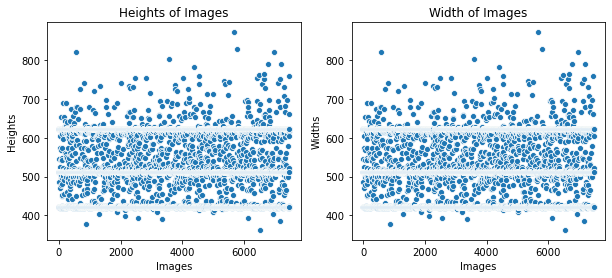

In [11]:
#plotting the heights and widths of images
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.xlabel('Images')
plt.ylabel('Heights')
plt.title('Heights of Images')
sns.scatterplot(range(len(h)), h)
plt.subplot(122)
plt.xlabel('Images')
plt.ylabel('Widths')
plt.title('Width of Images')
sns.scatterplot(range(len(w)), h)

The Heights and widths are not same for all the images

# PREPROCESSING IMAGE DATA

In [11]:
print('Total Images:', Dataset['Image_names'].nunique())


Total Images: 7470


In [12]:
# checking for missing values
Dataset.isnull().sum()

Image_names      0
Finding        997
dtype: int64

In [13]:
# drop all missing value rows
Dataset = Dataset.dropna(axis=0) 

In [14]:
Dataset.isnull().sum()

Image_names    0
Finding        0
dtype: int64

In [15]:
print('Shape after preprocessing', Dataset.shape)

Shape after preprocessing (6473, 2)


In [16]:
Dataset.head(10)

,Image_names,Finding
0,x ray data/CXR1_1_IM-0001-3001.png,The cardiac silhouette and mediastinum size ar...
1,x ray data/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
2,x ray data/CXR10_IM-0002-1001.png,The cardiomediastinal silhouette is within nor...
3,x ray data/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
4,x ray data/CXR100_IM-0002-1001.png,Both lungs are clear and expanded. Heart and m...
5,x ray data/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
6,x ray data/CXR1000_IM-0003-1001.png,There is XXXX increased opacity within the rig...
7,x ray data/CXR1000_IM-0003-2001.png,There is XXXX increased opacity within the rig...
8,x ray data/CXR1000_IM-0003-3001.png,There is XXXX increased opacity within the rig...
9,x ray data/CXR1001_IM-0004-1001.png,Interstitial markings are diffusely prominent ...


TypeError: Image data of dtype object cannot be converted to float

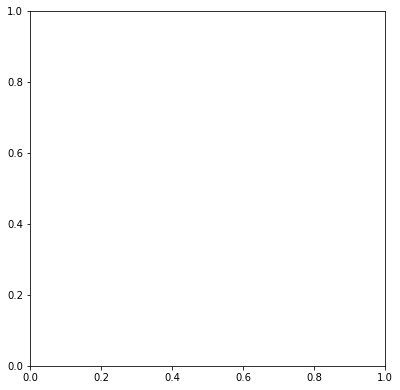

In [17]:
#printing images of two points
plt.figure(figsize=(14,7))
plt.subplot(121)
img1 = cv2.imread(Dataset['Image_names'].values[4])
plt.imshow(img1)
plt.title(Dataset['Image_names'].values[4])
plt.subplot(122)
img2 = cv2.imread(Dataset['Image_names'].values[5])
plt.title(Dataset['Image_names'].values[5])
plt.imshow(img2)


In [18]:
#printing findings of two points
Dataset['Finding'].values[4], Dataset['Finding'].values[5]

('Both lungs are clear and expanded. Heart and mediastinum normal.',
 'Both lungs are clear and expanded. Heart and mediastinum normal.')

Here we see that two reports are same  and the above images are also same but with a different angle.So we need to find images and reports like this.

In [19]:
# we are creating two dictionaries with image id and number of times it is present in dataset and findings of each report. 
images = {}
findings = {}
for image, find in Dataset.values:
    i = image.split('-')#splitting the image at '-'
    i.pop(len(i)-1)#removing the numbers after - to find the x rays of same patient
    i = '-'.join(e for e in i)
    if i not in images.keys():
        images[i] = 1
        findings[i] = find
    else:
        images[i] += 1
        findings[i] = find

In [20]:
images[r'x ray data/CXR1001_IM-0004'], findings[r'x ray data/CXR1001_IM-0004']

(2,
 'Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal.')

In [23]:
print('Total Number of unique images:', len(images.keys()))

Total Number of unique images: 3350


Here we can see that there are about 3350 unique images present in the dataset

Text(0, 0.5, 'Images per Person')

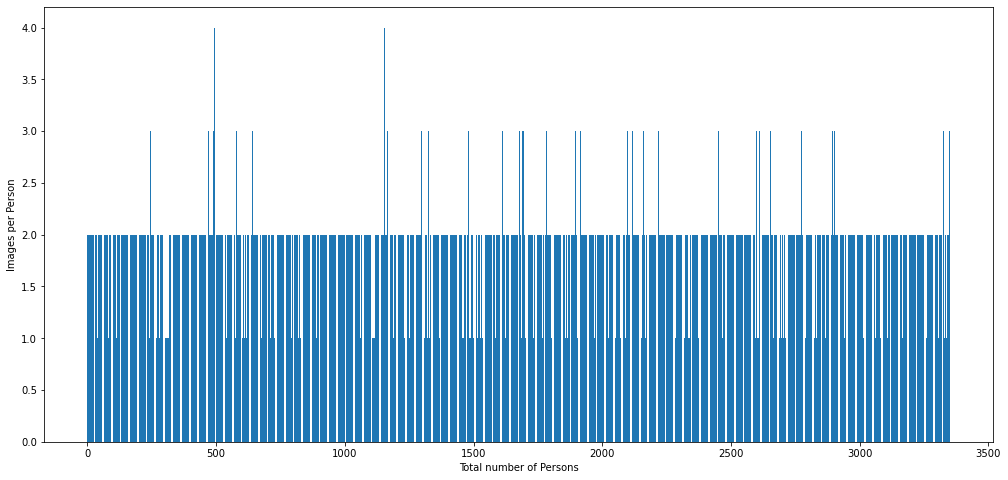

In [24]:
#plotting a bar plot to see how many images we have per each person
plt.figure(figsize=(17,8))
plt.bar(range(len(images.keys())), images.values())
plt.xlabel('Total number of Persons')
plt.ylabel('Images per Person')

In [25]:
one = 0
two = 0
three = 0
four = 0
for i in images.values():
    if i == 1:
        one +=1
    elif i == 2:
        two += 1
    elif i == 3:
        three += 1
    elif i == 4:
        four += 1
    else:
        print('Error')
print(one, two, three, four)

390 2807 143 10


Here We can see that majority of people have 2 images and 4 being maximum only 10 people have 4 images.

In [25]:
len(images)

3350

In [26]:
len(findings)

3350

# SPLITTING THE DATA

In [34]:
Data = list(images.keys())
Data_train = Data[:2500]
Data_cv = Data[2500:3000]
Data_test = Data[3000:3350]  

In [35]:
def combining_images(images):
    
    image_per_person = defaultdict(list)  # creating a list of dictionary to store all the image paths
                                            #corresponding to a person_id
    for pid in images:
        for img in Dataset['Image_names'].values:
            if pid in img:
                image_per_person[pid].append(img)
            else:
                continue
    return image_per_person

In [36]:
img_train = combining_images(Data_train)
img_cv = combining_images(Data_cv)
img_test = combining_images(Data_test)

In [37]:
len(img_train), len(Data_train)

(2500, 2500)

In [38]:
img_train['x ray data/CXR1_1_IM-0001']

['x ray data/CXR1_1_IM-0001-3001.png', 'x ray data/CXR1_1_IM-0001-4001.png']

In [39]:
def load_image(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [40]:
# checking which points have 4 images
for k,v in images.items():
    if v == 4:
        print(k)
        break

x ray data/CXR1102_IM-0069


Text(0.5, 1.0, 'CXR1102_IM-0069-4004.png')

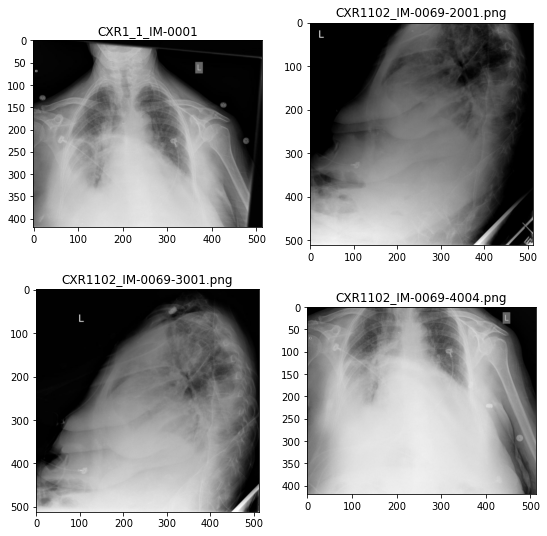

In [41]:
#plotting the four images of the point
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(load_image(r'C:\Users\venka\OneDrive\Desktop\cs2\x ray data/CXR1102_IM-0069-12012.png'))
plt.title('CXR1_1_IM-0001')
plt.subplot(222)
plt.imshow(load_image(r'C:\Users\venka\OneDrive\Desktop\cs2\x ray data/CXR1102_IM-0069-2001.png'))
plt.title('CXR1102_IM-0069-2001.png')
plt.subplot(223)
plt.imshow(load_image(r'C:\Users\venka\OneDrive\Desktop\cs2\x ray data/CXR1102_IM-0069-3001.png'))
plt.title('CXR1102_IM-0069-3001.png')
plt.subplot(224)
plt.imshow(load_image(r'C:\Users\venka\OneDrive\Desktop\cs2\x ray data/CXR1102_IM-0069-4004.png'))
plt.title('CXR1102_IM-0069-4004.png')

We have same scan in different angleslike front and sides.We have points with 1,2,3,4 scans per person in which majority have 2 scans.So we can take pair of Images as input to generate findings and The points with 1 scan can be augmented with same scan to have 2 scans for it.

# CREATING FINAL DATA

In [42]:
def final_data(image_per_person):
    # new dataset
    Person_id, image_1, image_2, Findings = [],[],[],[]
    for pid, imgs in image_per_person.items():   #contains pid and the images associated with that pid

        if len(imgs) == 1:
            image_1.append(imgs[0])
            image_2.append(imgs[0])
            Person_id.append(pid)
            Findings.append(findings[pid])
        else:
            num = 0
            a = itertools.combinations(imgs, 2)
            for i in a:
                image_1.append(i[0])
                image_2.append(i[1])
                Person_id.append(pid + '_' + str(num))
                Findings.append(findings[pid])
                num += 1
    data = pd.DataFrame()
    data['Person_id'] = Person_id
    data['Image-1'] = image_1
    data['Image-2'] = image_2
    data['Findings'] = Findings
    
    return data

In [43]:
Train_data = final_data(img_train)
Test_data = final_data(img_test)
CV_Data = final_data(img_cv)

In [44]:
print(Train_data.shape)
print(Test_data.shape)
print(CV_Data.shape)

(2758, 4)
(399, 4)
(550, 4)


In [45]:
Train_data.head()

,Person_id,Image-1,Image-2,Findings
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,There is XXXX increased opacity within the rig...
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,There is XXXX increased opacity within the rig...


# TEXT PREPROCESSING

In [46]:
#https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [47]:
def Preprocessing(text):
    '''Combining all the functions'''
    pre_text = lowercase(text)
    pre_text = decontractions(pre_text)
    pre_text = rem_punctuations(pre_text)
    pre_text = rem_numbers(pre_text)
    pre_text = words_filter(pre_text)
    pre_text = multiple_fullstops(pre_text)
    pre_text = fullstops(pre_text)
    pre_text = multiple_spaces(pre_text)
    pre_text = separting_startg_words(pre_text)
    pre_text = rem_apostrophes(pre_text)
    return pre_text

In [48]:
Train_data['Findings'] = Preprocessing(Train_data['Findings'])
Test_data['Findings'] = Preprocessing(Test_data['Findings'])
CV_Data['Findings'] = Preprocessing(CV_Data['Findings'])

In [49]:
Train_data.head()

,Person_id,Image-1,Image-2,Findings
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,there increased opacity within the right upper...
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,there increased opacity within the right upper...


In [50]:
#finding number of words in each report
words = [len(i.split()) for i in Train_data['Findings'].values] 
print(max(words))

153


Text(0.5, 1.0, 'Words in each Report')

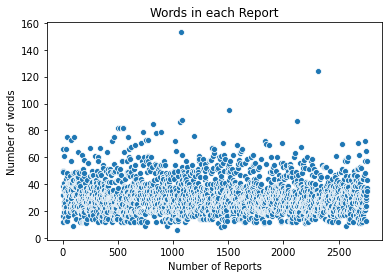

In [51]:
#plotting scatter plot for number of words in each report
sns.scatterplot(range(Train_data.shape[0]), words)
plt.xlabel('Number of Reports')
plt.ylabel('Number of words')
plt.title('Words in each Report')


Here we can see that majority of the reports contains 20 to 60 words.

In [47]:
#finding number of words in train,cv,test data
train_words = []
for i in Train_data['Findings'].values:
    train_words.extend(i.split())
test_words = []
for i in Test_data['Findings'].values:
    test_words.extend(i.split())
cv_words = []
for i in CV_Data['Findings'].values:
    cv_words.extend(i.split())
print('total number of words in train data',len(train_words))
print('total number of words in test data',len(test_words))
print('total number of words in cv data',len(cv_words))

total number of words in train data 87458
total number of words in test data 12521
total number of words in cv data 18000


In [48]:
#finding unique words from total words
train_c= Counter(train_words)
test_c = Counter(test_words)
cv_c   = Counter(cv_words)

print('Number of Unique words in train data',len(train_c))
print('Number of Unique words in test data',len(test_c))
print('Number of Unique words in cv data',len(cv_c))

Number of Unique words in train data 1424
Number of Unique words in test data 735
Number of Unique words in cv data 804


In [49]:
#printing 50 most common words from train data
print(train_c.most_common(50))

[('.', 12558), ('the', 5102), ('no', 3647), ('are', 3457), ('normal', 2831), ('and', 2254), ('pleural', 1982), ('there', 1979), ('pneumothora', 1956), ('effusion', 1817), ('heart', 1736), ('lungs', 1584), ('size', 1569), ('focal', 1407), ('within', 1270), ('clear', 1187), ('limits', 1178), ('pulmonary', 970), ('consolidation', 864), ('silhouette', 800), ('right', 769), ('mediastinal', 686), ('airspace', 682), ('cardiomediastinal', 665), ('left', 641), ('acute', 574), ('lung', 566), ('with', 510), ('unremarkable', 507), ('disease', 491), ('stable', 489), ('spine', 481), ('mediastinum', 475), ('structures', 472), ('changes', 461), ('contours', 446), ('thoracic', 436), ('bony', 433), ('contour', 419), ('mild', 388), ('degenerative', 380), ('large', 373), ('seen', 359), ('appear', 336), ('opacity', 333), ('osseous', 332), ('without', 331), ('calcified', 323), ('cardiac', 318), ('effusions', 311)]


In [50]:
#printing most common words from test data
print(test_c.most_common(50))

[('.', 1773), ('the', 706), ('no', 526), ('are', 501), ('normal', 410), ('and', 338), ('pleural', 304), ('pneumothora', 279), ('there', 274), ('heart', 267), ('effusion', 265), ('size', 233), ('lungs', 228), ('focal', 225), ('clear', 177), ('limits', 173), ('within', 163), ('pulmonary', 143), ('consolidation', 129), ('silhouette', 116), ('right', 104), ('cardiomediastinal', 103), ('mediastinal', 101), ('airspace', 100), ('lung', 89), ('stable', 86), ('left', 82), ('changes', 77), ('with', 76), ('acute', 75), ('disease', 72), ('mediastinum', 69), ('contour', 69), ('spine', 67), ('contours', 63), ('large', 62), ('thoracic', 60), ('without', 57), ('vascularity', 56), ('appear', 55), ('unremarkable', 55), ('seen', 53), ('degenerative', 52), ('for', 49), ('calcified', 49), ('bony', 47), ('effusions', 47), ('structures', 46), ('upper', 45), ('cardiac', 43)]


In [51]:
#printing 50 most common words from cv data
print(cv_c.most_common(50))

[('.', 2525), ('the', 1082), ('no', 737), ('are', 725), ('normal', 557), ('and', 440), ('pleural', 424), ('there', 407), ('pneumothora', 406), ('effusion', 385), ('heart', 337), ('lungs', 310), ('focal', 303), ('size', 294), ('limits', 265), ('within', 252), ('clear', 248), ('consolidation', 180), ('pulmonary', 177), ('silhouette', 176), ('airspace', 153), ('cardiomediastinal', 143), ('with', 141), ('right', 140), ('left', 139), ('mediastinal', 137), ('structures', 110), ('changes', 106), ('stable', 105), ('lung', 105), ('spine', 104), ('acute', 103), ('disease', 102), ('mediastinum', 97), ('thoracic', 91), ('bony', 91), ('unremarkable', 90), ('degenerative', 83), ('without', 82), ('contours', 81), ('intact', 79), ('large', 75), ('cardiac', 72), ('contour', 72), ('osseous', 69), ('mild', 69), ('for', 67), ('opacity', 65), ('upper', 63), ('abnormality', 63)]


In [52]:
#common words between train ,test and cv
common_train_cv = train_c & cv_c &test_c
print(len(common_train_cv))

521


In [53]:
#printing 50 most common words present in all train,test,cv
common_train_cv.most_common(50)

[('.', 1773),
 ('the', 706),
 ('no', 526),
 ('are', 501),
 ('normal', 410),
 ('and', 338),
 ('pleural', 304),
 ('pneumothora', 279),
 ('there', 274),
 ('heart', 267),
 ('effusion', 265),
 ('size', 233),
 ('lungs', 228),
 ('focal', 225),
 ('clear', 177),
 ('limits', 173),
 ('within', 163),
 ('pulmonary', 143),
 ('consolidation', 129),
 ('silhouette', 116),
 ('right', 104),
 ('cardiomediastinal', 103),
 ('mediastinal', 101),
 ('airspace', 100),
 ('lung', 89),
 ('stable', 86),
 ('left', 82),
 ('changes', 77),
 ('with', 76),
 ('acute', 75),
 ('disease', 72),
 ('mediastinum', 69),
 ('contour', 69),
 ('spine', 67),
 ('contours', 63),
 ('large', 62),
 ('thoracic', 60),
 ('without', 57),
 ('unremarkable', 55),
 ('vascularity', 54),
 ('seen', 53),
 ('degenerative', 52),
 ('for', 49),
 ('calcified', 49),
 ('appear', 47),
 ('bony', 47),
 ('effusions', 47),
 ('structures', 46),
 ('upper', 45),
 ('cardiac', 43)]

Here we can see that there are about 87,000 words in train data most of the words are repeated and we see that there are only 1424 unique words in train data and 735,804 in test and validation data respectively.And also we can see that most common words in all these sets are almost same.

In [54]:
common = train_c & cv_c
print(len(common))

701


In [55]:
print('{0} % of train words present in cv data'.format(len(common)/len(train_c)*100))

49.22752808988764 % of train words present in cv data


In [56]:
common_1 = train_c & test_c
print(len(common_1))

655


In [57]:
print('{0} % of train words present in cv data'.format(len(common_1)/len(train_c)*100))

45.997191011235955 % of train words present in cv data


Here we can see that only 50% of the words that are present in validation data are present in train data.
And only about 46% of the words that are present in test data are present in train data.

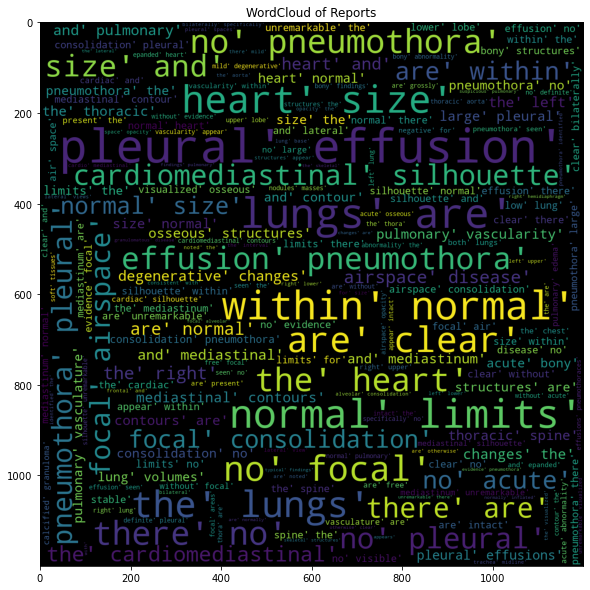

In [58]:
words=[]
for i in Train_data['Findings'].values:
    words.extend(i.split())
w = WordCloud(height=1200, width=1200).generate(str(words))
plt.figure(figsize=(10,10))
plt.title('WordCloud of Reports')
plt.imshow(w)

In [59]:
#function for adding start of sentence and end of sequence in reports
def add(x):
    return 'SOS' + ' ' + x + ' ' + 'EOS'

In [60]:
Train_data['Findings'] = Train_data['Findings'].apply(lambda x : add(x))
Test_data['Findings'] = Test_data['Findings'].apply(lambda x : add(x))
CV_Data['Findings'] = CV_Data['Findings'].apply(lambda x : add(x))

In [61]:
#dumping data to csv files
Train_data.to_csv('Train_Data.csv', index=False)
Test_data.to_csv('Test_Data.csv', index=False)
CV_Data.to_csv('CV_Data.csv', index=False)

In [52]:
frames = [Train_data,CV_Data,Test_data]
data = pd.concat(frames)

In [55]:
data[-5:]

,Person_id,Image-1,Image-2,Findings
394,x ray data/CXR997_IM-2479_0,x ray data/CXR997_IM-2479-1001.png,x ray data/CXR997_IM-2479-2001.png,calcified mediastinal no focal areas consolida...
395,x ray data/CXR998_IM-2479_0,x ray data/CXR998_IM-2479-1001.png,x ray data/CXR998_IM-2479-2001.png,cardiomediastinal silhouette demonstrates norm...
396,x ray data/CXR999_IM-2480_0,x ray data/CXR999_IM-2480-1001.png,x ray data/CXR999_IM-2480-2001.png,lungs are clear bilaterally . there no focal ...
397,x ray data/CXR999_IM-2480_1,x ray data/CXR999_IM-2480-1001.png,x ray data/CXR999_IM-2480-3001.png,lungs are clear bilaterally . there no focal ...
398,x ray data/CXR999_IM-2480_2,x ray data/CXR999_IM-2480-2001.png,x ray data/CXR999_IM-2480-3001.png,lungs are clear bilaterally . there no focal ...


In [57]:
#saving in a pickle file
from pickle import dump
dump(data,open('Dataset_1.pkl','wb'))